# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [61]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [62]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-15 08:38:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [                <=> ] 201.24M  62.0MB/s    in 3.6s    

2023-10-15 08:38:31 (56.2 MB/s) - ‘data.txt.zip’ saved [211011981]



In [63]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [64]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [65]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [66]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [67]:
set_random_seed(777)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [68]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train_scaled, y_train)

y_predicted = model.predict(X_test_scaled)

rmse_for_model = np.sqrt(mean_squared_error(y_test, y_predicted))
rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [69]:
y_mean = np.full_like(y_test, np.mean(y_train))
best_rmse_metric = np.sqrt(mean_squared_error(y_test, y_mean))
best_rmse_metric

10.863228020678134

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [70]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx, :], dtype=torch.float), self.y[idx]

In [71]:
train_dataset = MyDataset(X_train_scaled, y_train)
test_dataset = MyDataset(X_test_scaled, y_test)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=1
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False, num_workers=1
)

In [72]:
model = nn.Linear(X_train.shape[1], 1)
lr = 0.1

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 0, train_loss: 1817.4495849609375,  test_loss: 1636.292724609375


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 1, train_loss: 1455.1656494140625,  test_loss: 1274.07080078125


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 2, train_loss: 1092.9578857421875,  test_loss: 911.8369140625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 3, train_loss: 730.7731323242188,  test_loss: 549.7135009765625


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 4, train_loss: 368.6651916503906,  test_loss: 187.7238311767578


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 5, train_loss: 54.7885856628418,  test_loss: 9.999141693115234


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 6, train_loss: 10.882245063781738,  test_loss: 9.99059009552002


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 7, train_loss: 10.88296127319336,  test_loss: 9.99002742767334


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 8, train_loss: 10.884638786315918,  test_loss: 9.988739013671875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 9, train_loss: 10.882427215576172,  test_loss: 9.99842643737793


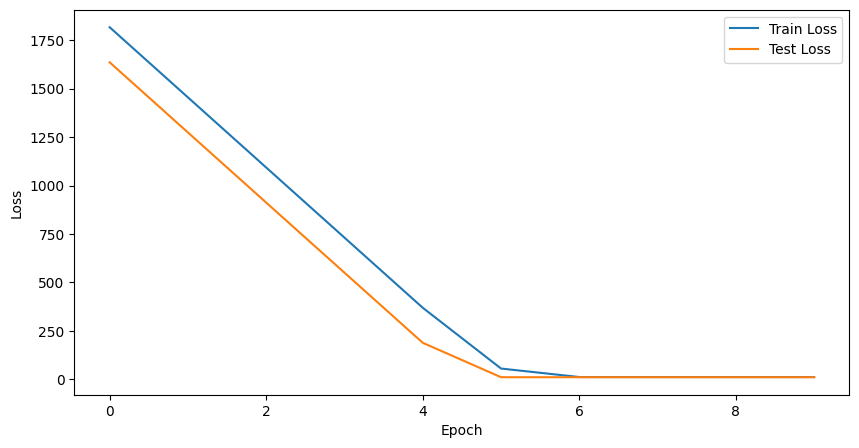

In [73]:
train_loss_main = []
test_loss_main = []

for epoch in range(10):
    model.train()
    train_loss = []
    test_loss = []

    for x_train, y_train in tqdm(train_dataloader):
        x_train, y_train = x_train.to(device), y_train.to(device)
        y_pred = model(x_train)

        loss = torch.sqrt(torch.mean((y_pred - y_train)**2))
        train_loss.append(loss.detach().numpy())

        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad
                param.grad.zero_()

    train_loss_main.append(np.mean(train_loss))


    with torch.no_grad():
        model.eval()
        for x_test, y_test in tqdm(test_dataloader):
            x_test, y_test = x_test.to(device), y_test.to(device)
            y_pred_test = model(x_test)

            test_batch_loss = torch.sqrt(torch.mean((y_pred_test - y_test)**2))
            test_loss.append(test_batch_loss.cpu().numpy())

    print(
            f"Epoch: {epoch}, train_loss: {np.mean(train_loss)},  test_loss: {np.mean(test_loss)}"
        )
    test_loss_main.append(np.mean(test_loss))

plt.figure(figsize=(10, 5))
plt.plot(train_loss_main, label='Train Loss')
plt.plot(test_loss_main, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [74]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

Эксперимент 1. Для начала отскейлерим наши данные как советовали выше

In [75]:
from sklearn.preprocessing import StandardScaler

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [76]:
dataset_train = MyDataset(X_train_scaled, y_train_scaled)
dataset_test = MyDataset(X_test_scaled, y_test_scaled)

train_dataloader = torch.utils.data.DataLoader(
    dataset_train, batch_size=128, shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset_test, batch_size=128, shuffle=True
)

In [77]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, n_epoch):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    train_loss_main  = []
    val_loss_main = []
    for epoch in range(n_epoch):

        train_epoch_loss = torch.empty(0)
        model.train()
        for x_train, y_train in tqdm(train_dataloader):

            x_train, y_train = x_train.to(device), y_train.to(device)

            y_pred = model(x_train).squeeze()

            loss = torch.sqrt(criterion(y_pred, y_train.float().squeeze()))

            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            train_epoch_loss = torch.cat((train_epoch_loss, loss.unsqueeze(0)))

        train_loss_main.append(train_epoch_loss.mean().item())

        val_epoch_loss = torch.empty(0)
        model.eval()
        with torch.no_grad():
            for x_val, y_val in tqdm(val_dataloader):
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_pred_val = model(x_val).squeeze()

                loss = torch.sqrt(criterion(y_pred_val, y_val.float().squeeze()))

                val_epoch_loss = torch.cat((val_epoch_loss, loss.unsqueeze(0)))

        val_loss_main.append(val_epoch_loss.mean())
        print(f"Epoch: {epoch}, train_loss: { train_epoch_loss.mean().item()},  val_loss: {val_epoch_loss.mean().item()}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss_main, label='Train Loss')
    plt.plot(val_loss_main, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def test(model, x_test):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        x_test - torch.tensor with test data
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    return model(x_test)


Проверим по модели из задания 1, что функцию test написали адекватно

In [78]:
criterion = nn.MSELoss()

In [79]:
assert test(model, torch.tensor(X_test).float()).shape[0] == y_test.shape[0]

Так как при обучении мы будем использваоть отскейленные данные то итоговый loss посчитанный на таких данных это не совсем тот формат, который мы можем корректно интерпретировать. Чтобы видеть корректный и понятный результат, используем функцию, чтобы считать RMSE на не отксейленных данных

In [ ]:
def test_RMSE(model, y_pred, y_test):
  return mean_squared_error(y_scaler.inverse_transform(y_pred.data.numpy()).squeeze(), y_test, squared=False)

Для первого эксперимента возьмем нейронную сеть с 3 слоями, где один будет скрытый, а между слоями будет  функуция релаксации

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 0, train_loss: 0.8099879026412964,  val_loss: 0.8056350350379944


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.7875673770904541,  val_loss: 0.8026591539382935


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.7790021896362305,  val_loss: 0.7987295389175415


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 3, train_loss: 0.7728465795516968,  val_loss: 0.8003047704696655


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.7676173448562622,  val_loss: 0.8008878231048584


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.762900173664093,  val_loss: 0.7980247139930725


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 6, train_loss: 0.7589510679244995,  val_loss: 0.8035924434661865


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 7, train_loss: 0.7554050087928772,  val_loss: 0.8090412616729736


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 8, train_loss: 0.7514451146125793,  val_loss: 0.8038435578346252


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 9, train_loss: 0.7484064698219299,  val_loss: 0.8038209676742554


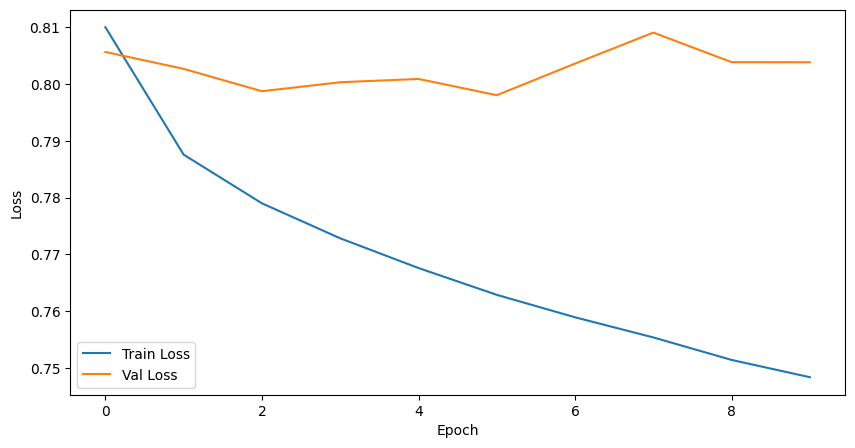

RMSE = 8.85314005617566


In [81]:
set_random_seed(777)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train(model, criterion, optimizer, train_dataloader, test_dataloader, 10)
print(f'RMSE = {test_RMSE(model, test(model, torch.tensor(X_test_scaled).float()), y_test)}')

Судя по графиук можно увидеть что на тесте rmse сначала падал, но под конец только увеличился. Это признак переобучения. Чтобы решить эту проблему попробуем использовать LayerNorm и Dropout, сначал по отдельности а затем посмотрим как они будут работать вместе

Эксперимент 2. Добавим LayerNorm для борьбы с переобучением

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 0, train_loss: 0.8065165281295776,  val_loss: 0.8035959601402283


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.7869791388511658,  val_loss: 0.8001776933670044


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.7790035605430603,  val_loss: 0.7983754277229309


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 3, train_loss: 0.7728090286254883,  val_loss: 0.799271285533905


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.7678074240684509,  val_loss: 0.7957243919372559


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.7633270025253296,  val_loss: 0.795261561870575


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 6, train_loss: 0.7589108943939209,  val_loss: 0.7984861731529236


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 7, train_loss: 0.7556062936782837,  val_loss: 0.8004562854766846


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 8, train_loss: 0.7517861127853394,  val_loss: 0.8010449409484863


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 9, train_loss: 0.748635470867157,  val_loss: 0.8008118271827698


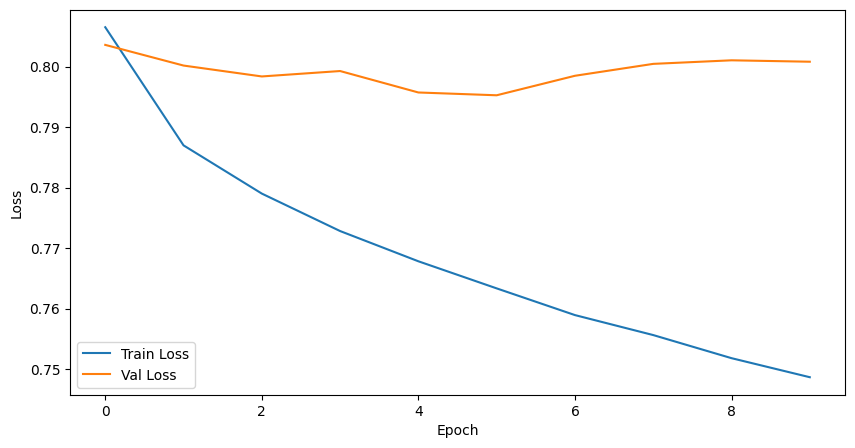

RMSE = 8.820434070560038


In [82]:
set_random_seed(777)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.LayerNorm(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.LayerNorm(64),
    nn.ReLU(),
    nn.Linear(64, 1))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train(model, criterion, optimizer, train_dataloader, test_dataloader, 10)
print(f'RMSE = {test_RMSE(model, test(model, torch.tensor(X_test_scaled).float()), y_test)}')

Видно что результат стал получше, но под конец rmse на тесте все равно оказался не минемальным. Попробуем посмотреть как нам поможет Dropout

Эксперимент 3. Попробуем Dropout для борьбы с переобучением

Судя по данным из интернета обычно коэффициент для лежит в промежутке от 0.2 до 0.4. Попробуем посмотреть что нам лучше подойдет, рассмотрев коэффициенты 0.2, 0.4 и 0.6



Эксперимент 3.1. Dropout с коэффициентом 0.4

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 0, train_loss: 0.8372462391853333,  val_loss: 0.8117465972900391


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.8147439360618591,  val_loss: 0.8058861494064331


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.8094242215156555,  val_loss: 0.80375736951828


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 3, train_loss: 0.8064910173416138,  val_loss: 0.805351197719574


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.8039071559906006,  val_loss: 0.8025263547897339


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.8028687238693237,  val_loss: 0.8020080924034119


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 6, train_loss: 0.801287055015564,  val_loss: 0.7996059656143188


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 7, train_loss: 0.8005075454711914,  val_loss: 0.8007328510284424


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 8, train_loss: 0.7991448640823364,  val_loss: 0.7978048324584961


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 9, train_loss: 0.7977645397186279,  val_loss: 0.7993194460868835


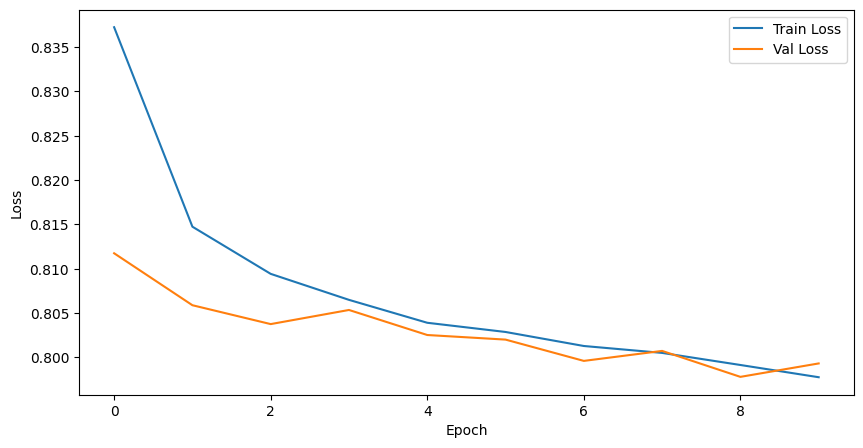

RMSE = 8.806696372477731


In [83]:
set_random_seed(777)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(64, 1))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train(model, criterion, optimizer, train_dataloader, test_dataloader, 10)
print(f'RMSE = {test_RMSE(model, test(model, torch.tensor(X_test_scaled).float()), y_test)}')

Потрясающий результат! Так шикрано, что rmse на тесте стал даже меньше чем на трейне в среднем.

Эксперимент 3.2. Попробуем увеличить коэффициент в Dropout до 0.6

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 0, train_loss: 0.8566266298294067,  val_loss: 0.8195396065711975


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.8309608101844788,  val_loss: 0.8113586902618408


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.8261415362358093,  val_loss: 0.8087041974067688


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 3, train_loss: 0.8247928619384766,  val_loss: 0.8143486380577087


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.8226549625396729,  val_loss: 0.8070797324180603


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.8215903639793396,  val_loss: 0.8075441122055054


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 6, train_loss: 0.8204197883605957,  val_loss: 0.8044140338897705


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 7, train_loss: 0.8198560476303101,  val_loss: 0.8049086928367615


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 8, train_loss: 0.8183050155639648,  val_loss: 0.8030850291252136


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 9, train_loss: 0.8174663186073303,  val_loss: 0.8038535714149475


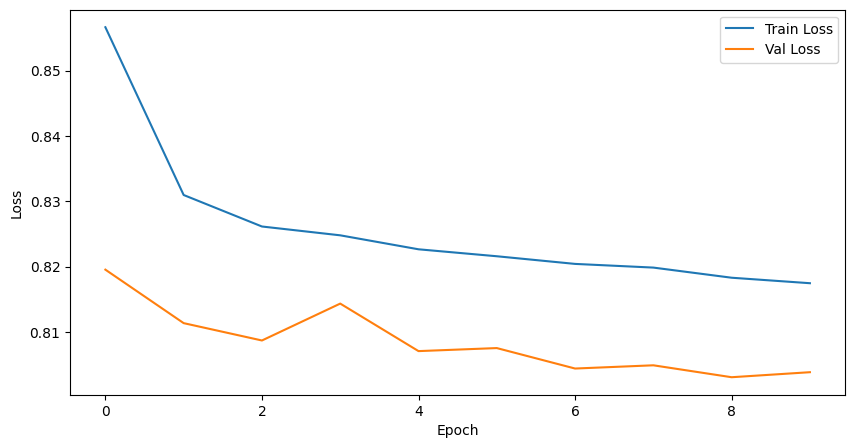

RMSE = 8.85746624551959


In [84]:
set_random_seed(777)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(64, 1))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train(model, criterion, optimizer, train_dataloader, test_dataloader, 10)
print(f'RMSE = {test_RMSE(model, test(model, torch.tensor(X_test_scaled).float()), y_test)}')

Большой коэффициент не помог уменьшить rmse, получили почти то же самое что и без него. По эксперименту видно что 60% вероятность отключения каждого нейрона это слишком много - отключается слишком много нейронов, шумов становится много, теряется много иформации, поэтому RMSE не улучшился

Эксперимент 3.3. Попробуем уменьшить коэффициент в Dropout до 0.2

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 0, train_loss: 0.8234747648239136,  val_loss: 0.8073769807815552


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.8024917244911194,  val_loss: 0.8019704818725586


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.7964136600494385,  val_loss: 0.8014115691184998


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 3, train_loss: 0.7919801473617554,  val_loss: 0.8023519515991211


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.7891343235969543,  val_loss: 0.799703061580658


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.787541925907135,  val_loss: 0.7983266711235046


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 6, train_loss: 0.785534143447876,  val_loss: 0.798775315284729


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 7, train_loss: 0.7833763360977173,  val_loss: 0.7991307377815247


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 8, train_loss: 0.7821847796440125,  val_loss: 0.7957426309585571


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 9, train_loss: 0.7800556421279907,  val_loss: 0.7962347865104675


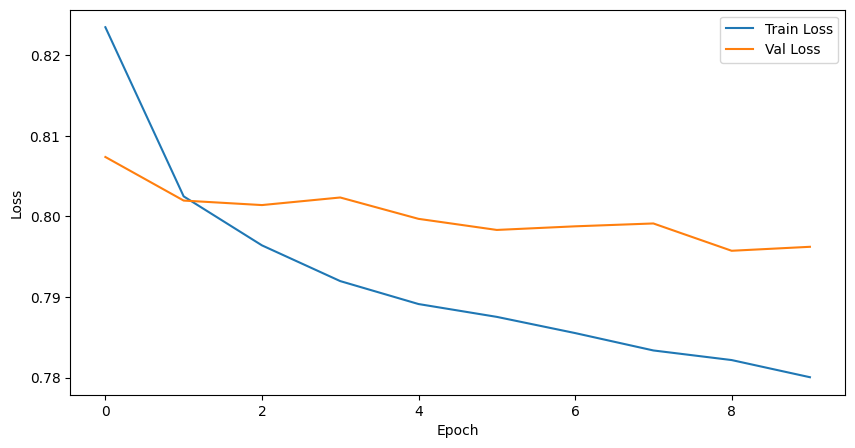

RMSE = 8.77388188651217


In [85]:
set_random_seed(777)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 1))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train(model, criterion, optimizer, train_dataloader, test_dataloader, 10)
print(f'RMSE = {test_RMSE(model, test(model, torch.tensor(X_test_scaled).float()), y_test)}')

Лучший коэффициент 0.2 - с ним и будем работать дальше

Эксперимент 4. Попробуем совместить лучший коэффициент Dropout и LayerNorm для борьбы с переобучением

  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 0, train_loss: 0.8201988935470581,  val_loss: 0.8063890337944031


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 1, train_loss: 0.8013432025909424,  val_loss: 0.800506591796875


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 2, train_loss: 0.7948518991470337,  val_loss: 0.8010810613632202


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 3, train_loss: 0.7905523180961609,  val_loss: 0.7994300127029419


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 4, train_loss: 0.7875123620033264,  val_loss: 0.7966779470443726


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 5, train_loss: 0.7853264212608337,  val_loss: 0.7960361242294312


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 6, train_loss: 0.7832382917404175,  val_loss: 0.7961664199829102


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 7, train_loss: 0.7810765504837036,  val_loss: 0.7950131297111511


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 8, train_loss: 0.7795191407203674,  val_loss: 0.7941742539405823


  0%|          | 0/3623 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Epoch: 9, train_loss: 0.7771790027618408,  val_loss: 0.7937619090080261


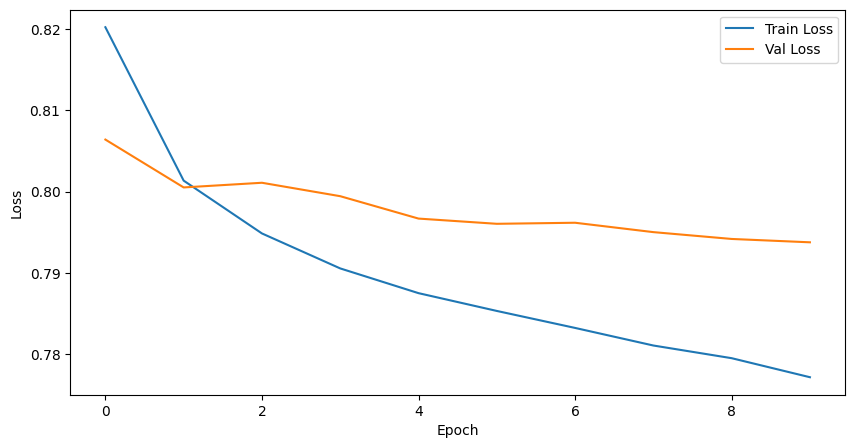

RMSE = 8.747188080112117


In [86]:
set_random_seed(777)

model = nn.Sequential(
    nn.Linear(90, 128),
    nn.LayerNorm(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 64),
    nn.LayerNorm(64),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(64, 1))

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train(model, criterion, optimizer, train_dataloader, test_dataloader, 10)
print(f'RMSE = {test_RMSE(model, test(model, torch.tensor(X_test_scaled).float()), y_test)}')

Наш лучший результат!

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Во многом код был написан с опорой на семинары, так что может быть некоторые части будут похожи

Все началось с простой нейронной сети, включающей в себя 3 слоя, из которых 1 скрытый, а между слоями в качетсве фукции активации использовали функуция релаксации.  

Для красоты число нейронов в созданных слоях взяты как степени двойки с надеждой что это как-то упростит вычисления и будет эффективно для работы, так как многие аппаратные ускорители (например пример GPU), легче обрабатывают размеры, являющиеся степенями двойки.


По такой же идеи batch_size = 128 (достаточно большой чтобы была терпимая скорость обучения но и не огромная чтобы не делать шумов в градиентах)

**Эксперимент 1.** Посмотрим как скейлинг таргета повлияет на результат.

RMSE такой модели составило 8.85314005617566, а по графику видно переобучение за счет возрастания loss-а на тесте под конец

После этого очевидно что стоит решить данную проблему с переобучением. Как варианты использовать слои нормализации nn.LayerNorm и использовать слои регуляризации nn.Dropout. Попробуем сначала посмотреть данные методы решения по отдельности, а затем лучшие варианты в каждом способе соединим в одну модель

**Эксперимент 2.** Используем nn.LayerNorm для борьбы с переобучением.
Полученный RMSE - 8.820434070560038, действительно лучше чем без него но мы хотим получить результат еще лучше

**Эксперимент 3.** Использование nn.Dropout

После серчинга в интренете сложилось впечатление что коэффициентом исключения (коэффциент который мы скармливаем в Dropout) обычно лежит в границах от 0.2 до 0.4. Нужно посмотреть несколько значений и выбрать какое будет максимально полезным для уменьшения итогового RMSE



*   **Эксперимент 3.1** коэффициент исключения = 0.4  
Слои регуляризации действительно помогли, RMSE стал 8.806696372477731
*   **Эксперимент 3.2** коэффициент исключения = 0.6  
Слои регуляризации вообще не помогли, результат почти такой же как в самой первой простой модели
*   **Эксперимент 3.3** коэффициент исключения = 0.2  
Слои регуляризации шикарно помогли, RMSE стал 8.77388188651217, что делает коэффициент исключения = 0.2 самым полезнвм и именно с ним мы и будем работать дальше

**Эксперимент 3.** Использование лучшего nn.Dropout + nn.LayerNorm

Получили шикарный результат - RMSE =  8.747188080112117
